In [55]:
import pandas as pd 
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer

### LIMPIEZA DE DATOS

##### TAMAÑO DEL DF

In [56]:
path='c:/Users/afonseca/Desktop/data_market.csv'
df=pd.read_csv(path,encoding='ISO-8859-1',delimiter=';',index_col='Row ID')

##### TAMAÑO DEL DF

In [57]:
print(f'el tamaño del dataframe es de {df.shape[0]} filas y {df.shape[1]} columnas')

el tamaño del dataframe es de 9994 filas y 20 columnas


##### TIPO COLUMNAS

In [58]:
columnas_numericas=df.select_dtypes(include=['number']).columns
columnas_categoricas=df.select_dtypes(include=['object']).columns
print(f'la cantidad de columnas numericas es {len(columnas_numericas)} y la de categoricas es {len(columnas_categoricas)}')

la cantidad de columnas numericas es 3 y la de categoricas es 17


##### CAMBIAR TIPO STRING A FLOAT

In [59]:
def remplazos(df):
    df['Profit'] = df['Profit'].str.replace('.','')
    df['Profit'] = df['Profit'].astype('Float64')
    df['Sales'] = df['Sales'].str.replace('.','')
    df['Sales'] = df['Sales'].astype('Float64')
    
    return df
    

In [60]:
df=remplazos(df)

##### VALORES NULLOS 

In [61]:
nullos=df.isnull().sum().reset_index()
nullos=nullos.rename(columns={'index':'columnas',0:'nullos_c'})
nullos=nullos[nullos.nullos_c>0]
nullos=nullos.set_index('columnas')
print(f'el numero de columnas con datos nullos es de {nullos.shape[0]}\
 para un total de {np.array(nullos.nullos_c).sum()} datos nullos en todo el data set')
nullos


el numero de columnas con datos nullos es de 4 para un total de 24 datos nullos en todo el data set


,nullos_c
columnas,
Sales,6
Quantity,6
Discount,6
Profit,6


##### FILTRAR VALORES NULLOS EN DF 

In [62]:
filtered_df = df[df.isna().any(axis=1)]

##### % VALORES NULLOS 

In [63]:
nullos['%']=round((nullos['nullos_c']/df.shape[0])*100,3)
nullos.loc['total'] = ['=',np.array(nullos['%']).sum()]
nullos

,nullos_c,%
columnas,,
Sales,6,0.06
Quantity,6,0.06
Discount,6,0.06
Profit,6,0.06
total,=,0.24


##### REMPLAZAR NULLOS POR PROMEDIO

In [64]:
#df.replace(np.nan, 0,inplace=True)
# Reemplazar TSH por la media
mean_imputer = SimpleImputer(strategy='mean')
df.loc[:,['Sales','Quantity','Discount','Profit']] \
        = mean_imputer.fit_transform(df[['Sales','Quantity','Discount','Profit']])


In [65]:
# SE VERIFICA QUE NO HAY VALORES NULLOS
df.isnull().values.any()

False

##### VALORES DUPLICADOS

In [66]:
df.index.duplicated().sum()

0

##### SELECCION DE FEATURES Y AGREGAR FUNCIONES DE TIEMPO

In [67]:
def tiempo(df):
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['año']=df['Ship Date'].dt.year
    df['mes']=df['Ship Date'].dt.month
    df['dia']=df['Ship Date'].dt.day
    return df

In [68]:
# se borra pais por que solo tiene un solo country 
df__=df.loc[:,['Ship Date','Ship Mode','Customer Name','Segment','City','State','Category','Sub-Category','Quantity','Profit']]
df__=tiempo(df__)


##### VALORES UNICOS 

In [69]:
def unicos(df):
    unicos={i:df[i].nunique()  for i in df.columns }
    return pd.DataFrame(unicos,index=['unicos'])\
            .T.sort_values(by='unicos',ascending=True)

In [70]:
unicos_=unicos(df__)
unicos_

,unicos
Segment,3
Category,3
Ship Mode,4
año,5
mes,12
Quantity,15
Sub-Category,17
dia,31
State,49
City,531


Al examinar los valores únicos, se puede detectar la diversidad y la distribución de los datos en cada variable, lo que ayuda a comprender mejor las relaciones y patrones presentes

##### MEDIDAS ESTADISTICAS  PROFIT

In [71]:
promedio_profit=round(np.array(df__['Profit']).mean(),0)
max_profit=round(np.array(df__['Profit']).max(),0)
min_profit=round(np.array(df__['Profit']).min(),0)
desv_=round(np.array(df__['Profit']).std(),0)
Q1=np.percentile(np.array(df__['Profit']),25)
Q3=np.percentile(np.array(df__['Profit']),75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

##### RESUMEN ESTADISTICO

In [72]:
resumen={
    'promedio_profit':promedio_profit,
    'max_profit':max_profit,
    'min_profit':min_profit,
    'desv_':desv_,
    'Q1':Q1,
    'Q3':Q3,
    'limite_inferior':limite_inferior,
    'limite_superior':limite_superior
}
resumen=pd.DataFrame(resumen,index=['resumen'])
resumen

,promedio_profit,max_profit,min_profit,desv_,Q1,Q3,limite_inferior,limite_superior
resumen,179906.0,67199808.0,-38399904.0,1722850.0,2245.0,151083.0,-221012.0,374340.0


##### AGRUPAR DATOS

##### conteo por segmento

In [73]:
# segmento por cliente
segmento=df__.groupby(['Segment'])['Segment'].count()
segmento=segmento.reset_index(name='conteo')
segmento

,Segment,conteo
0,Consumer,5191
1,Corporate,3020
2,Home Office,1783


##### conteo por ciudad y suma de profit

In [74]:
ciudad=df__.groupby(['City'])['Profit'].sum()
ciudad=ciudad.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
ciudad['valores'] = ciudad['sum'].apply(lambda x: '{:,.0f}'.format(x))
conteo=df__.groupby(['City'])['City'].count()
conteo=conteo.reset_index(name='conteo')
df_result=pd.merge(ciudad,conteo,on='City')
df_result=df_result.iloc[:,[0,2,3]]
df_result

,City,valores,conteo
0,New York City,"389,435,030",915
1,Seattle,"219,116,376",428
2,Los Angeles,"178,925,628",747
3,San Francisco,"114,998,620",510
4,Jackson,"62,436,861",82
5,Minneapolis,"58,279,813",23
6,Detroit,"48,016,046",115
7,Newark,"47,684,473",95
8,Springfield,"43,863,451",163
9,San Diego,"41,332,287",170


##### profit estado

In [75]:
estado=df__.groupby(['State'])['Profit'].sum()
estado=estado.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
estado['valores'] = estado['sum'].apply(lambda x: '{:,.0f}'.format(x))
estado=estado.iloc[:,[0,2]]
estado

,State,valores
30,New York,"474,152,868"
3,California,"456,584,921"
45,Washington,"243,373,153"
20,Michigan,"116,291,759"
44,Virginia,"113,575,719"
9,Georgia,"87,997,758"
6,Delaware,"87,637,536"
21,Minnesota,"79,633,762"
28,New Jersey,"72,401,896"
15,Kentucky,"67,409,238"


##### categorias mas frecuentes

In [76]:
categoria=df__.groupby('Category')['Category'].count()
categoria=categoria.reset_index(name='conteo')
categoria_s=df__.groupby('Category')['Profit'].sum()
categoria_s=categoria_s.reset_index(name='suma')
categoria_s['valores'] = categoria_s['suma'].apply(lambda x: '{:,.0f}'.format(x))
categoria_s=pd.merge(categoria,categoria_s,on='Category')
categoria_s=categoria_s.iloc[:,[0,1,3]]
categoria_s

,Category,conteo,valores
0,Furniture,2121,"59,222,369"
1,Office Supplies,6026,"775,994,074"
2,Technology,1847,"962,768,841"


##### pedidos a lo largo del tiempo

In [125]:
años_=df__.groupby('año')['año'].count()
años_=años_.reset_index(name='conteo')
años_

,año,conteo
0,2014,1940
1,2015,2131
2,2016,2578
3,2017,3303
4,2018,42


##### Analisis Grafico

##### grafica  de tendencia de pedidos

¿ que tipo de tendencia tiene los pedidos en los ultimos años?

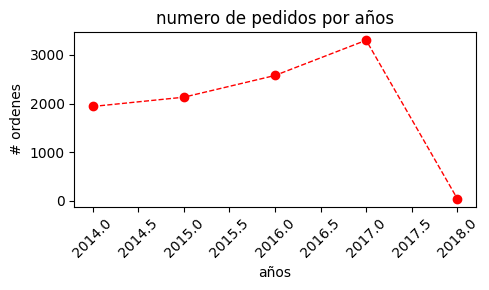

In [137]:
fig,ax = plt.subplots( figsize=(5, 3))

ax.plot(años_['año'],años_['conteo'],color='red',marker='o',linestyle='--',linewidth=1)

plt.xticks(rotation=45)
plt.xlabel('años')
plt.ylabel('# ordenes')

ax.set_title('numero de pedidos por años')

plt.tight_layout()
plt.show()



In [78]:
df.head(1)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,26196.0,2.0,0.0,419136.0
